In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node
from nipype.interfaces.freesurfer import WatershedSkullStrip
from nilearn import plotting
import pylab as plt
import numpy as np



# Plot

/home/quacktab/miniconda3/envs/ds/lib/python3.11/site-packages/nilearn/image/resampling.py:867: UserWarning: Casting data from int32 to float32
  return resample_img(


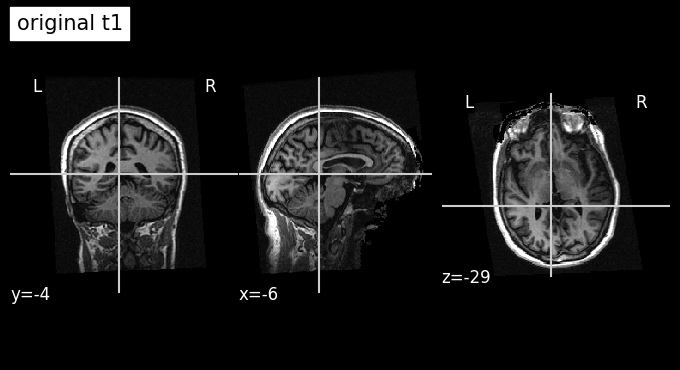

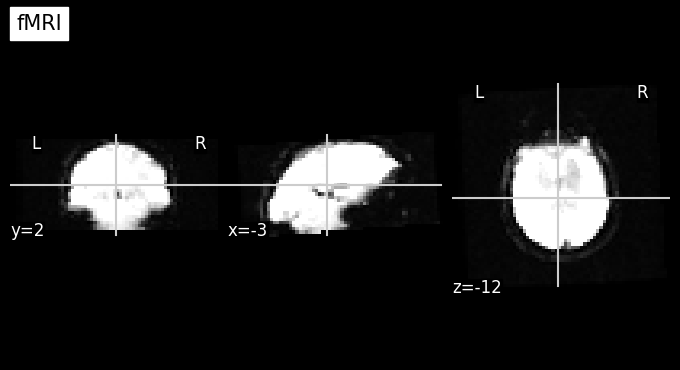

In [3]:
from nilearn import image as nli

t1 = nli.load_img('./data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
bold = nli.load_img('./data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

plotting.plot_anat(t1, title='original t1', display_mode="ortho", dim=-1,)
plotting.plot_anat(bold.slicer[...,30], title='fMRI', display_mode="ortho", dim=-1,)

# Skull striping

# Registration

In [4]:
experiment_dir = './output'
working_dir = 'workingdir'


# TR of functional images
with open('./sub1/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

In [5]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=False,
                       out_file='mcflirt_plot',
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")



## Registration workflow

In [6]:

# watershed_freesurfer = Node(BET(frac=0.5,
#                     robust=True,
#                     output_type='NIFTI_GZ'),
#                 name="watershed_freesurfer")

watershed_freesurfer = Node(WatershedSkullStrip(
    t1 = True, transform = "transforms/talairach_with_skull.lta",
    out_file = 'skull_strip.nii'),
                name="watershed_freesurfer")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                    name="segmentation", mem_gb=4)

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(watershed_freesurfer, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (watershed_freesurfer, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (watershed_freesurfer, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (watershed_freesurfer, applywarp_mean, [('out_file', 'reference')]),
                 ])

## Output

In [25]:
# # Infosource - a function free node to iterate over the list of subject names
# infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
#                   name="infosource")
# infosource.iterables = [('subject_id', subject_list),
#                         ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('ses-test', 'anat', 'sub-01_ses-test_T1w.nii.gz')
func_file = opj('ses-test', 'func',
                'sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/mnt/d/project/data-science-lectures/image_processing/sub1'),
                   name="selectfiles")


## All workflow

In [26]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([
    # (infosource, selectfiles, [('subject_id', 'subject_id'),
    #                                         ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'watershed_freesurfer.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),


                 ])

250603-22:10:52,74 nipype.workflow INFO:
	 Generated workflow graph: ./output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


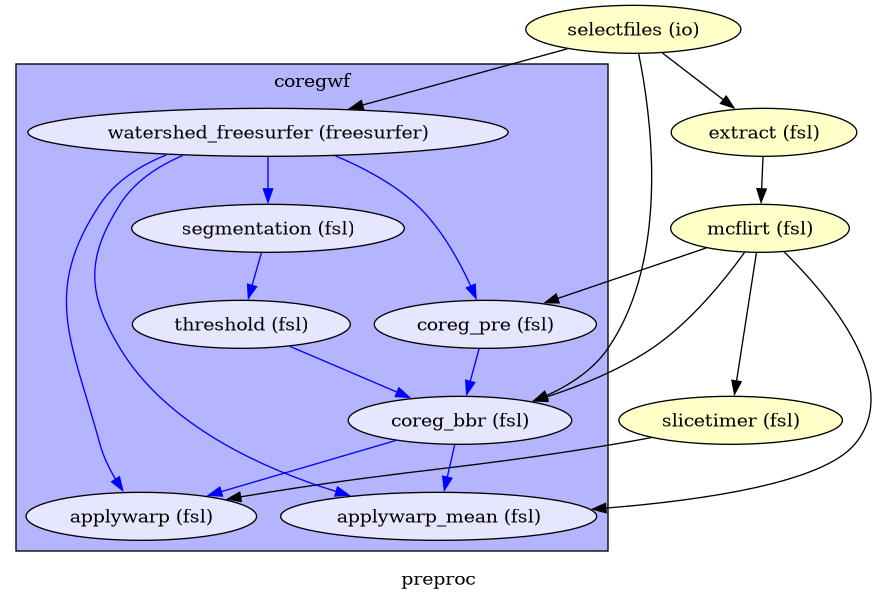

In [27]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

250603-22:10:53,89 nipype.workflow INFO:
	 Generated workflow graph: /mnt/d/project/data-science-lectures/image_processing/output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


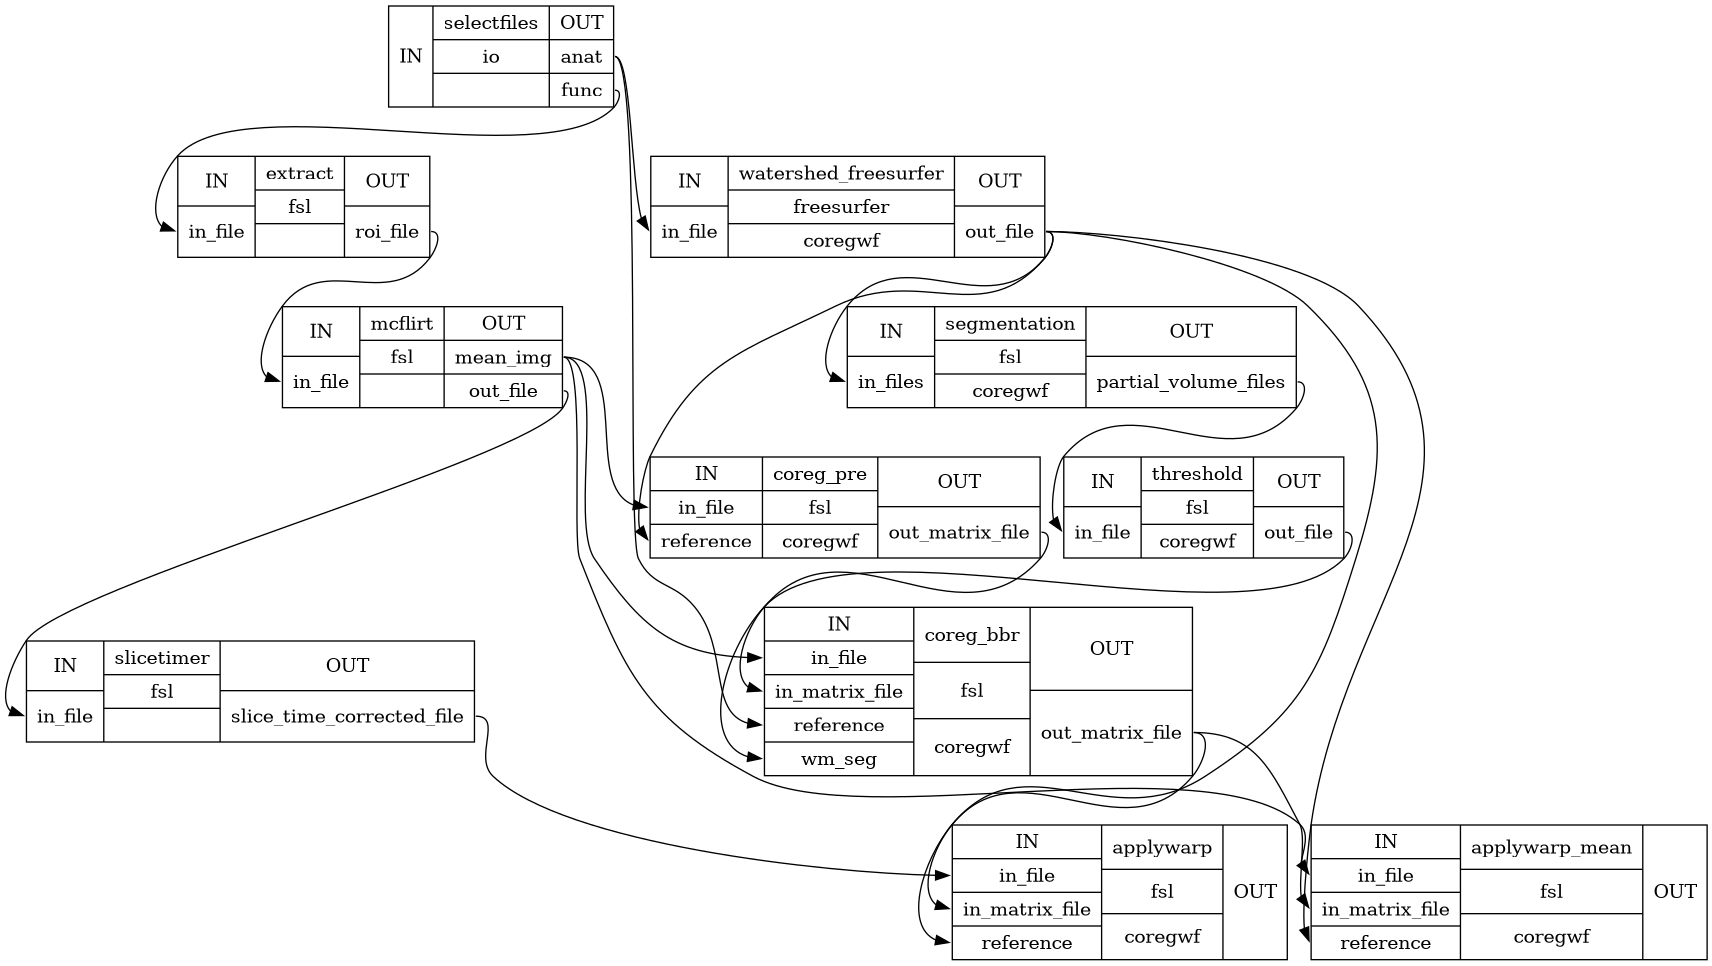

In [28]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

In [29]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

250603-22:10:53,726 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
250603-22:10:53,905 nipype.workflow INFO:
	 Running in parallel.
250603-22:10:53,908 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 6.93/6.93, Free processors: 4/4, Free GPU slot:1/1.
250603-22:10:54,163 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/mnt/d/project/data-science-lectures/image_processing/output/workingdir/preproc/selectfiles".
250603-22:10:54,295 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
250603-22:10:54,321 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.012863s.
250603-22:10:55,912 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).
250603-22:10:55,917 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 6.93/6.93, Free processors: 4/4, Free GPU slot:1/1.
250603-22:10:56,24

In [ ]:
t1.header. 


AttributeError: 'Nifti1Header' object has no attribute 'descrip'

/tmp/ipykernel_17479/745412279.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  bold_mean = nli.mean_img(bold_mean)


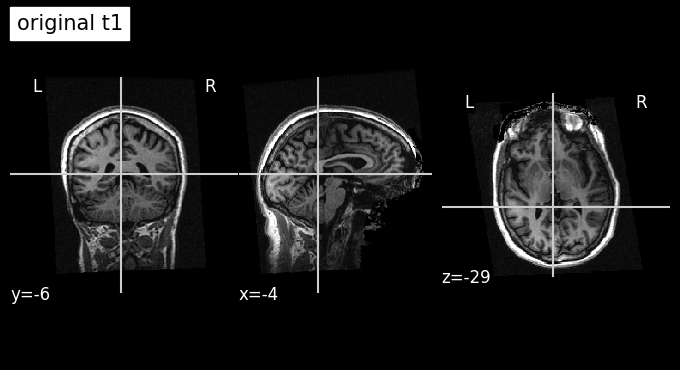

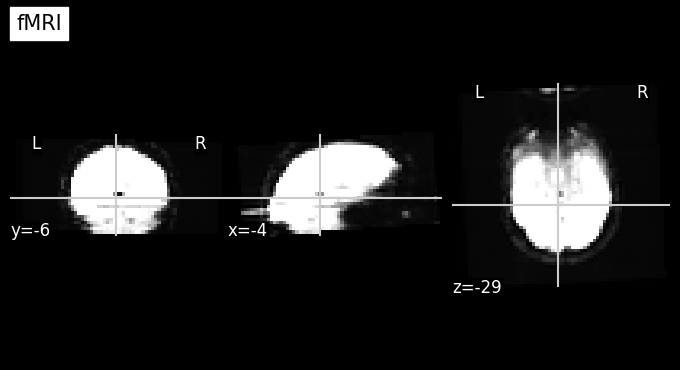

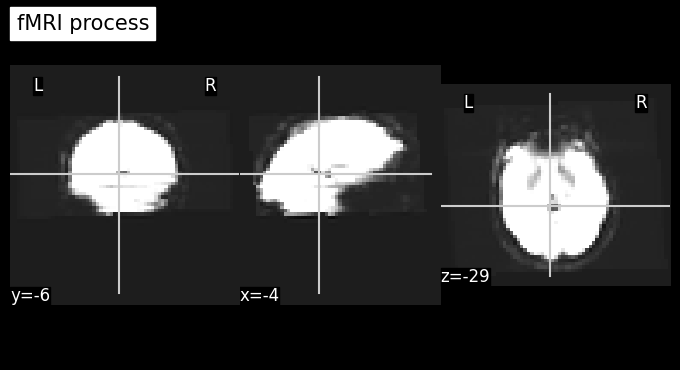

In [50]:
from nilearn import image as nli

t1 = nli.load_img('./sub1/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
bold_mean = nli.load_img('./sub1/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')
bold_mean = nli.mean_img(bold_mean)
bold_process = nli.load_img('./output/workingdir/preproc/coregwf/applywarp_mean/mcflirt_plot_mean_reg_flirt.nii.gz')

plotting.plot_anat(t1, title='original t1', display_mode="ortho", dim=-1,cut_coords=(-4,-6,-29))
plotting.plot_anat(bold_mean, title='fMRI', display_mode="ortho", dim=-1, cut_coords=(-4,-6,-29))
plotting.plot_anat(bold_process, title='fMRI process', display_mode="ortho", dim=-1, cut_coords=(-4,-6,-29))

In [45]:
t1.shape

(256, 156, 256)

In [35]:
origin = t1.affine[:3, 3]
origin

array([-125.26386261,  -73.13301086, -177.55429077])

In [36]:
origin = bold_process.affine[:3, 3]
origin

array([-122.26646423,  -73.01068878, -177.57992554])

In [37]:
origin = bold_mean.affine[:3, 3]
origin

array([130.64169312, -97.47322845, -80.64657593])